# DATA DISTRIBUTION CODE

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

font = {'family':'Bahnschrift', 'fontsize' : 16}

from matplotlib.gridspec import GridSpec as gspec

%matplotlib inline

## Radon concentrations
We import the radon concentrations measured. (RAW DATA)

In [7]:
DF = pd.read_excel('Radon concentrations data/Results_LR115.xlsx')

DF_data = DF[(DF['Concentracion_Bq_m3'].notna())] #Drop NA data
DF_data['Error_perc'] = DF_data.apply(lambda df: 100*np.abs(df['Concentracion_Bq_m3'] - df['Contramuestra'])/df['Concentracion_Bq_m3'], axis = 1) #Add error column
DF_data.ID_muestra = DF_data.ID_muestra.apply(lambda df : int(str(df)[:2]))

DF_data = DF_data.set_index('ID_casa')
np.std(DF_data.Resultado)

79.19878460487186

## Basic statistics

In [12]:
DF_data = DF_data.iloc[:,-2:]

Geo_mean = 1
for i in range(len(DF_data)):
    Geo_mean *= DF_data['Resultado'].iloc[i]
    
Geo_mean = Geo_mean**(1/len(DF_data))
print('Geometic mean', Geo_mean, '\n')
DF_data.describe().iloc[[1,2,3,7],:]
median


Geometic mean 90.84756604725008 



102.8375

## Compute the histogram

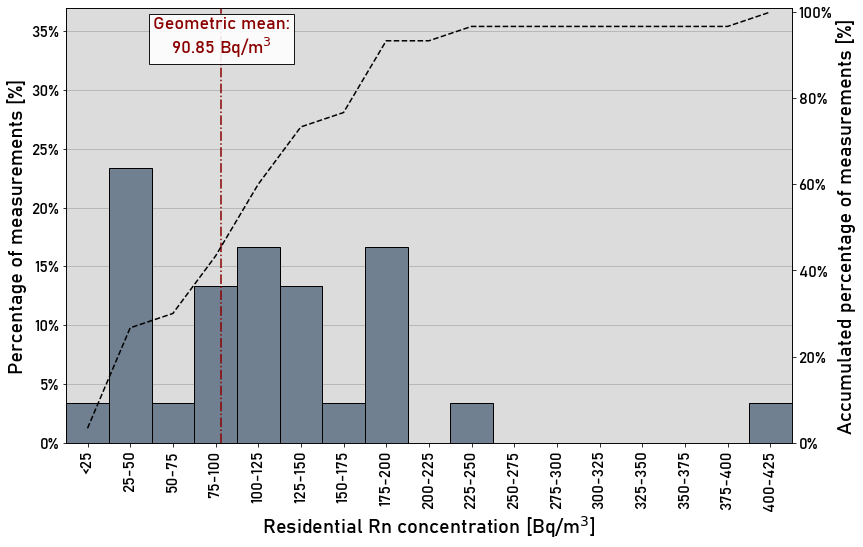

In [4]:
fig = plt.figure(figsize = (13,8))

plt.grid(axis='y', zorder = -1)

h = plt.hist(DF_data.Resultado, bins = np.arange(0,450,25), weights=np.ones(len(DF_data.Resultado)) / len(DF_data.Resultado), 
             edgecolor = 'k', color = 'slategray', zorder = 4)
median = DF_data.median().iloc[0]

ax = plt.gca()
ax.set_facecolor('gainsboro')

plt.ylabel('Percentage of measurements [%]',fontdict = font, fontsize = 20)
plt.xlabel('Residential Rn concentration [Bq/m$^3$]',fontdict = font, fontsize = 20)
plt.xticks(np.arange(12.5,420,25))
ax.set_xticklabels(['<25','25-50','50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-225','225-250','250-275',
                    '275-300','300-325','325-350','350-375','375-400','400-425'], fontdict = font, fontsize = 14, rotation = 90)
ax.set_yticklabels(['0%','5%', '10%', '15%', '20%', '25%','30%','35%'], fontdict = font, fontsize = 16)
plt.xlim((0,425))
ax.set_ylim((0,0.37))
# ax.text(3,0.38,'$n=$30', family = 'bahnschrift', fontsize = 16, bbox = {'facecolor':'w','edgecolor':'k'})


ax2 = ax.twinx() 
ax2.set_ylim((0,1.01))

plt.plot(np.arange(12.5,420,25),np.cumsum(h[0]), zorder=5, c = 'k', ls ='--')
ax2.set_yticklabels(['0%','20%', '40%', '60%', '80%', '100%'], fontdict = font, fontsize = 16)
ax2.set_ylabel('Accumulated percentage of measurements [%]', fontdict = font, fontsize = 20)

ax2.axvline(Geo_mean, c = 'darkred',ls='-.')
ax2.text(Geo_mean, 0.94,'Geometric mean:\n'+str(round(Geo_mean,2))+' Bq/m$^3$', va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9), family = font['family'], fontsize = 18, color = 'darkred')

fig.savefig('Figures/Rn_Histogram.png', dpi = 150)

## Data distribution with respect to reference values

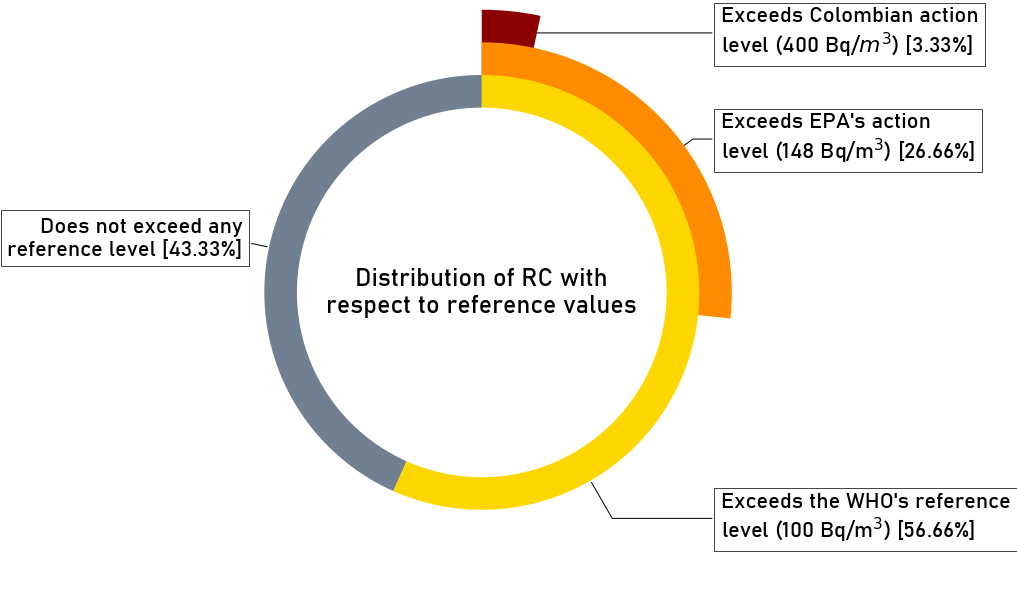

In [9]:
data_exceed = pd.DataFrame(DF_data.Resultado.apply(lambda df : 'Res. 18-1434 de 2002 [400 Bq/$m^3$]' if df > 400 else 'EPA' if df>148 else 'OMS' if df>100 else 'No sobrepasa ningún valor de referencia'))

# Pie plot
bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")
labels = ['Does not exceed any\nreference level', "Exceeds the WHO's reference\nlevel (100 Bq/m$^3$)","Exceeds EPA's action\nlevel (148 Bq/m$^3$)",'Exceeds Colombian action\nlevel (400 Bq/$m^3$)']

fig, ax = plt.subplots(figsize = (10,10), subplot_kw=dict(aspect="equal"))
wedges, texts = ax.pie(data_exceed.value_counts(), radius = 1.3
                       , colors = ['w','w','darkorange','darkred'],
                       explode = [-0.8,-0.8,0-0.8,0],startangle = 90, textprops = font)

Perc = [43.33, 56.66, 26.66, 3.33]

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i]+' ['+str(round(Perc[i],2))+'%]', xy=(x, y), xytext=(1.1*np.sign(x), 1.2*y),
                horizontalalignment=horizontalalignment, **kw, family = 'bahnschrift', fontsize=22)
    

wedges, texts = ax.pie([0.43333,1-0.4333-0.2666, 0.26666], radius = 1.15, colors = ['w','w','darkorange'], explode = [-0.7,-0.7,0], startangle=90)
wedges, texts = ax.pie([0.43333,1-0.4333], radius = 1, colors = ['slategray','gold'], startangle=90)
    
blank_pie = plt.pie([1], radius = 0.85, colors=['w'])
plt.text(0,0,'Distribution of RC with\nrespect to reference values', family = 'bahnschrift', fontsize=25, ha = 'center', va = 'center')

plt.savefig('Figures/CompaRefVal.png',dpi = 250, bbox_inches = "tight")

## Data distribution compared with Latin America & the Caribbean measurements

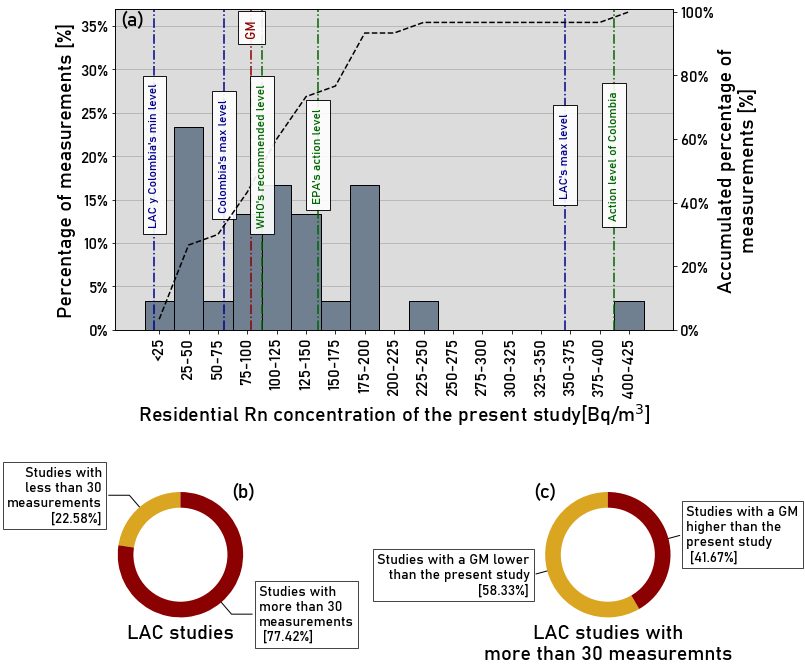

In [17]:
fig = plt.figure(figsize = (10,13))

plt.subplot2grid((2,8), (0,0), colspan=8)

plt.grid(axis='y', zorder = -1)

h = plt.hist(DF_data.Resultado, bins = np.arange(0,450,25), weights=np.ones(len(DF_data.Resultado)) / len(DF_data.Resultado), edgecolor = 'k', color = 'slategray', zorder = 4)
median = DF_data.median().iloc[0]

ax = plt.gca()
ax.set_facecolor('gainsboro')

plt.ylabel('Percentage of measurements [%]',fontdict = font, fontsize = 20)
plt.xlabel('Residential Rn concentration of the present study[Bq/m$^3$]',fontdict = font, fontsize = 20)
plt.xticks(np.arange(12.5,420,25))
ax.set_xticklabels(['<25','25-50','50-75', '75-100', '100-125', '125-150', '150-175', '175-200', '200-225','225-250','250-275',
                    '275-300','300-325','325-350','350-375','375-400','400-425','425-450'], fontdict = font, fontsize = 3, rotation = 90)
ax.set_yticklabels(['0%','5%', '10%', '15%', '20%', '25%','30%','35%'], fontdict = font, fontsize = 16)
plt.xlim((-25,450))
ax.set_ylim((0,0.37))
ax.text(-10,0.357,'(a)', va='center', ha='center',family = 'bahnschrift', fontsize=20,)

ax2 = ax.twinx() 
ax2.set_ylim((0,1.01))

plt.plot(np.arange(12.5,420,25),np.cumsum(h[0]), zorder=5, c = 'k', ls ='--')
ax2.set_yticklabels(['0%','20%', '40%', '60%', '80%', '100%'], fontdict = font, fontsize = 16)
ax2.set_ylabel('Accumulated percentage of\nmeasurements [%]', fontdict = font, fontsize = 20)

ax2.axvline(Geo_mean, c = 'darkred',ls='-.')
ax2.text(Geo_mean, 0.95,'GM', rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 13, color = 'darkred')

# ax2.axvline(median, c = 'darkred',ls='-.')
# ax2.text(median, 0.1,'Median', rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 13, color = 'darkred')

ax2.axvline(8.5, c = 'darkblue',ls='-.')
ax2.text(8.5, 0.55,"LAC y Colombia's min level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkblue')

ax2.axvline(67.5, c = 'darkblue',ls='-.')
ax2.text(67.5, 0.55,"Colombia's max level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkblue')

ax2.axvline(358, c = 'darkblue',ls='-.')
ax2.text(358, 0.55,"LAC's max level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkblue')

ax2.axvline(100, c = 'darkgreen',ls='-.')
ax2.text(100, 0.55,"WHO's recommended level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkgreen', zorder = 6)
ax2.axvline(148, c = 'darkgreen',ls='-.')
ax2.text(148, 0.55,"EPA's action level", rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkgreen', zorder = 6)
ax2.axvline(400, c = 'darkgreen',ls='-.')
ax2.text(400, 0.55,'Action level of Colombia', rotation = 90, va='center', ha='center', bbox = dict(facecolor='w', alpha=0.9, pad=7), family = font['family'], fontsize = 12, color = 'darkgreen', zorder = 6)

w = [7, 24]

ax = plt.subplot2grid((2,8),(1,0), colspan=2)

wedges, texts = plt.pie(w, radius = 1.2, startangle = 90, colors = ['goldenrod', 'darkred'], frame = True)

labels = ['Studies with\nless than 30\nmeasurements\n', 'Studies with\nmore than 30\nmeasurements\n']
Perc = [22.58, 77.42]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i]+' ['+str(round(Perc[i],2))+'%]', xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw, family = 'bahnschrift', fontsize=14)
    
plt.text(1.2,1.2,'(b)', va='center', ha='center',family = 'bahnschrift', fontsize=20)
plt.grid(True)
plt.pie([1], radius=0.9, colors=['w'])
plt.xlabel('LAC studies', family = 'bahnschrift', fontsize=20)

w = [14,10]

ax = plt.subplot2grid((2,8),(1,6), colspan=2)
wedges, texts = plt.pie(w, radius = 1.2, startangle = 90, colors = ['goldenrod', 'darkred'], frame = True)

labels = ['Studies with a GM lower\n than the present study', 'Studies with a GM\nhigher than the\npresent study']
Perc = [58.333, 41.666]
for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i]+'\n ['+str(round(Perc[i],2))+'%]', xy=(x, y), xytext=(1.5*np.sign(x), 1.5*y),
                horizontalalignment=horizontalalignment, **kw, family = 'bahnschrift', fontsize=14)
    
plt.text(-1.2,1.2,'(c)', va='center', ha='center',family = 'bahnschrift', fontsize=20)
plt.grid(True)
plt.pie([1], radius=0.9, colors=['w'])
plt.xlabel('LAC studies with\nmore than 30 measuremnts', family = 'bahnschrift', fontsize=20)

fig.savefig('Figures/HistogramComparativeDataRegion.png', dpi=250, bbox_inches = 'tight')